In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imutils import paths
import numpy as np
import pandas as pd
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import sklearn

In [2]:
def image_to_feature_vector(image, size=(64,64)):
    return cv2.resize(image,size).flatten()

def extract_color_histogram(image, bins=(8,8,8)):
    # extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180,0,256,0,256])
    
	# handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    # otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
    else:
        cv2.normalize(hist,hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [3]:
# grab the list of images that we'll be describing
print("[INFO] describing images...")
os.chdir(os.getcwd()+'\\flowers')
print(os.getcwd())

[INFO] describing images...
D:\Desktop Folder\Self Projects\kaggle-projects\Flower Recognition\flowers


In [4]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = []
i = 0
for x in os.walk(os.getcwd()):
    if i == 0:
        i += 1
        continue
    flower_label_name = x[0].split('\\')[-1]
    flower_type = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}
    for flowers in x[1:]:
        for flower in flowers:
            imagePath = os.getcwd()+f"\\{flower_label_name}"+f"\\{flower}"
            image = cv2.imread(imagePath)
            pixels = image_to_feature_vector(image)
            hist = extract_color_histogram(image)
            
            rawImages.append(pixels)
            features.append(hist)
            
            flower_label = flower_type[flower_label_name]
            labels.append(flower_label)
    print(f"{flower_label_name} Processed")
    
labels = to_categorical(labels, num_classes=5)

daisy Processed
dandelion Processed
rose Processed
sunflower Processed
tulip Processed


In [36]:
(x_train, x_test, y_train, y_test) = train_test_split(features, labels, test_size =0.25, stratify=labels)


print("[INFO] Evaluating Feature Accuracy")
model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model.fit(x_train,y_train)
acc = model.score(x_test,y_test)

print(f"[INFO] histogram accuracy: {acc*100:.2f}")

[INFO] Evaluating Feature Accuracy
[INFO] histogram accuracy: 29.81


              precision    recall  f1-score   support

       daisy       0.22      0.80      0.34       191
   dandelion       0.51      0.20      0.29       263
        rose       0.64      0.22      0.33       196
   sunflower       0.61      0.38      0.46       184
       tulip       0.63      0.23      0.34       246

    accuracy                           0.35      1080
   macro avg       0.52      0.37      0.35      1080
weighted avg       0.53      0.35      0.35      1080



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

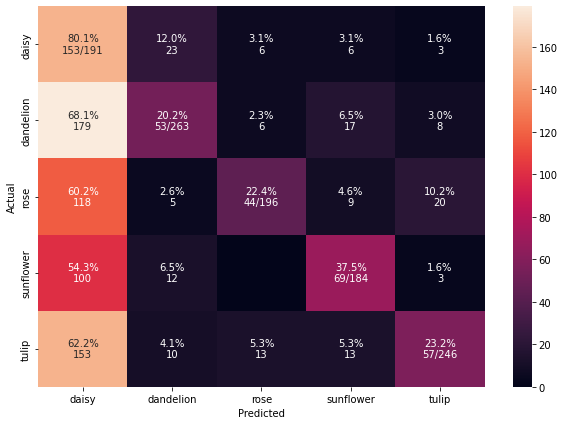

In [28]:
matrix_index = ["daisy", "dandelion", "rose","sunflower","tulip"]
preds = model.predict(x_test)
classpreds = np.argmax(preds, axis=1) # Predicted Classes
y_testclass = np.argmax(y_test, axis =1) # True classes

cm = confusion_matrix(y_testclass, classpreds)

print(classification_report(y_testclass, classpreds, target_names = matrix_index))\

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')